In [93]:
import os
import cv2
import numpy as np
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt



In [95]:
def eval(prediction, y_test, title, label_encoder):
     # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, prediction)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, prediction, average='macro')
    confusion_mat = confusion_matrix(y_test, prediction) # Compute confusion matrix
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [2, 1]})
    
    # Draw confusion matrix heatmap
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_ylabel('Actual')
    ax1.set_xlabel('Predicted')
    
    # Create label encoding table
    ax2.axis('off')
    label_mapping = [[str(i), label] for i, label in enumerate(label_encoder.classes_)]
    label_table = ax2.table(cellText=label_mapping,
                          colLabels=['Encoded', 'Label'],
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.2, 0.3])
    label_table.auto_set_font_size(False)
    label_table.set_fontsize(16)
    label_table.scale(1.2, 2)
    
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")


In [97]:
def load_flat_images_with_labels(folder_path):
    print(f"Loading images from {folder_path}...")
    images = []
    labels = []
    class_names = set()
    # Collect all image paths from the folder
    image_paths = glob(os.path.join(folder_path, "*.png")) + glob(os.path.join(folder_path, "*.jpg"))
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        if "_" not in filename:
            continue # Skip files without class prefix
        cls_name = filename.split("_")[0]  
        class_names.add(cls_name)

    class_names = sorted(list(class_names))  
    le = LabelEncoder() # Create label encoder
    le.fit(class_names) # Fit encoder to sorted class names
    class_to_idx = dict(zip(class_names, le.transform(class_names)))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            continue
        filename = os.path.basename(img_path)
        if "_" not in filename:
            continue
        cls_name = filename.split("_")[0]
        label = class_to_idx[cls_name]  # Convert class name to label

        images.append(img)
        labels.append(label)

    return images, labels, class_names, le


In [99]:
def extract_sift_descriptors(images):
    print("Extracting SIFT descriptors...")
    sift = cv2.SIFT_create() # Create a SIFT detector
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert image to grayscale
        kp, desc = sift.detectAndCompute(gray, None) # Detect keypoints and compute descriptors
        if desc is not None and len(desc) > 0:
            descriptors_list.append(desc)
        else:
            # If no descriptors, append a random one to avoid errors
            descriptors_list.append(np.random.rand(1, 128).astype(np.float32))
    return descriptors_list # Return a list of descriptors for each image


def build_visual_vocabulary(descriptors_list, n_clusters=100, max_samples=10000, random_state=42):
    print(f"Building visual vocabulary with {n_clusters} clusters...")
    all_desc = np.vstack([d for d in descriptors_list if len(d) > 0])
    if len(all_desc) > max_samples:
        np.random.seed(random_state)
        all_desc = all_desc[np.random.choice(len(all_desc), max_samples, replace=False)]
    # Cluster descriptors into visual words using MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(all_desc)

    # Return the trained k-means model
    return kmeans

def extract_bow_features(descriptors_list, kmeans):
    print("Extracting Bag-of-Words features...")
    n_clusters = kmeans.n_clusters
    features = []
    for desc in descriptors_list:
        hist = np.zeros(n_clusters)
        if desc is not None and len(desc) > 0:
            words = kmeans.predict(desc)  # Predict cluster assignments
            hist = np.bincount(words, minlength=n_clusters) # Count occurrences
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)


In [101]:
def extract_lbp_features(images, radius=1, n_points=8):
    print("Extracting LBP features...")
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Compute the LBP image with uniform pattern
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        # Compute histogram of LBP values
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")  # Convert histogram to float
        hist /= (hist.sum() + 1e-7)
        features.append(hist) # Append histogram as feature vector
    return np.array(features) # Return all feature vectors as a NumPy array


In [103]:
def train_and_evaluate(X_train, y_train, X_test, y_test, class_names, method_name=""):
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) # Fit on training data
    X_test = scaler.transform(X_test)

    # Initialize Support Vector Classifier
    clf = SVC(kernel="linear", class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n=== {method_name}  ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred, average='macro'):.4f}")

    print(classification_report(y_test, y_pred, target_names=class_names))
    print(confusion_matrix(y_test, y_pred))

    eval(y_pred, y_test, method_name, le)


In [105]:
train_path = "./normal_train/normal_train"
test_path = "./normal_test/normal_test"

train_images, train_labels, class_names, le = load_flat_images_with_labels(train_path)
test_images, test_labels, _, _ = load_flat_images_with_labels(test_path)


Loading images from ./normal_train/normal_train...
Loading images from ./normal_test/normal_test...


Extracting SIFT descriptors...
Extracting SIFT descriptors...
Building visual vocabulary with 100 clusters...


E:\software\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Extracting Bag-of-Words features...
Extracting Bag-of-Words features...

=== SIFT + BoVW + SVM  ===
Accuracy:  0.6146
Precision: 0.6118
Recall:    0.6146
F1-score:  0.6123
              precision    recall  f1-score   support

 Agriculture       0.65      0.62      0.63       160
     Airport       0.48      0.50      0.49       160
       Beach       0.54      0.54      0.54       160
        City       0.65      0.68      0.66       160
      Desert       0.52      0.63      0.57       160
      Forest       0.79      0.88      0.83       160
   Grassland       0.57      0.49      0.52       160
     Highway       0.55      0.54      0.55       160
        Lake       0.35      0.33      0.34       160
    Mountain       0.76      0.76      0.76       160
     Parking       0.83      0.86      0.84       160
        Port       0.69      0.66      0.67       160
     Railway       0.65      0.62      0.64       160
 Residential       0.77      0.75      0.76       160
       River     

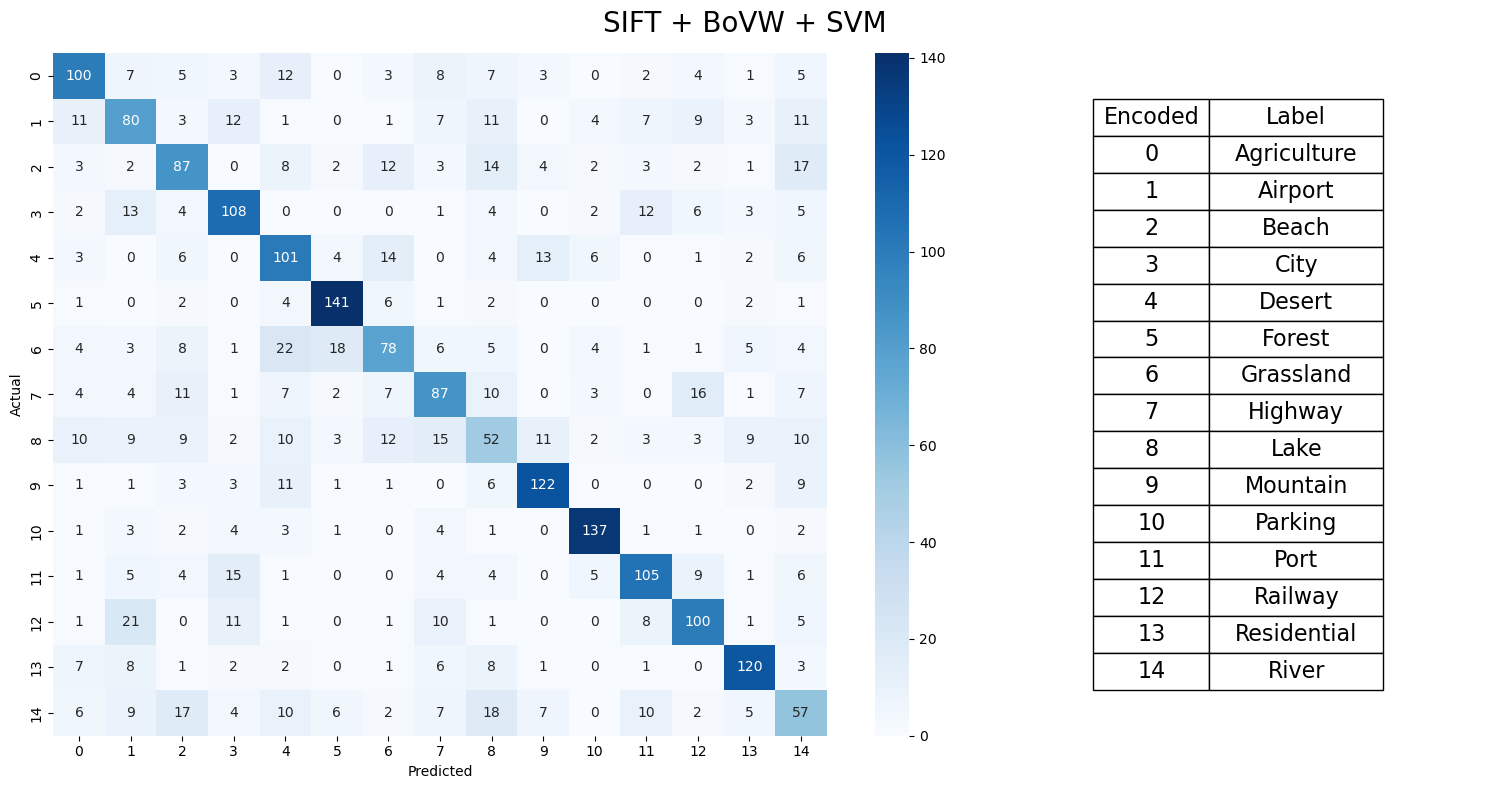

Accuracy: 0.6146
Precision: 0.6118
Recall: 0.6146
F1 Score: 0.6123


In [107]:
# Extract SIFT descriptors for training and test images
train_desc = extract_sift_descriptors(train_images)
test_desc = extract_sift_descriptors(test_images)

# Build a visual vocabulary using descriptors from training images
kmeans = build_visual_vocabulary(train_desc)

# Convert SIFT descriptors into BoVW feature vectors
X_train_sift = extract_bow_features(train_desc, kmeans)
X_test_sift = extract_bow_features(test_desc, kmeans)

# Train and evaluate the classifier using SVM
train_and_evaluate(X_train_sift, train_labels, X_test_sift, test_labels, class_names, method_name="SIFT + BoVW + SVM")


Extracting LBP features...
Extracting LBP features...

=== LBP + SVM  ===
Accuracy:  0.4958
Precision: 0.4975
Recall:    0.4958
F1-score:  0.4890
              precision    recall  f1-score   support

 Agriculture       0.49      0.53      0.51       160
     Airport       0.33      0.29      0.31       160
       Beach       0.45      0.34      0.39       160
        City       0.41      0.36      0.39       160
      Desert       0.45      0.51      0.47       160
      Forest       0.65      0.82      0.73       160
   Grassland       0.68      0.72      0.70       160
     Highway       0.42      0.38      0.40       160
        Lake       0.66      0.42      0.51       160
    Mountain       0.42      0.73      0.53       160
     Parking       0.47      0.47      0.47       160
        Port       0.73      0.69      0.71       160
     Railway       0.44      0.39      0.41       160
 Residential       0.42      0.50      0.46       160
       River       0.45      0.29      0.35

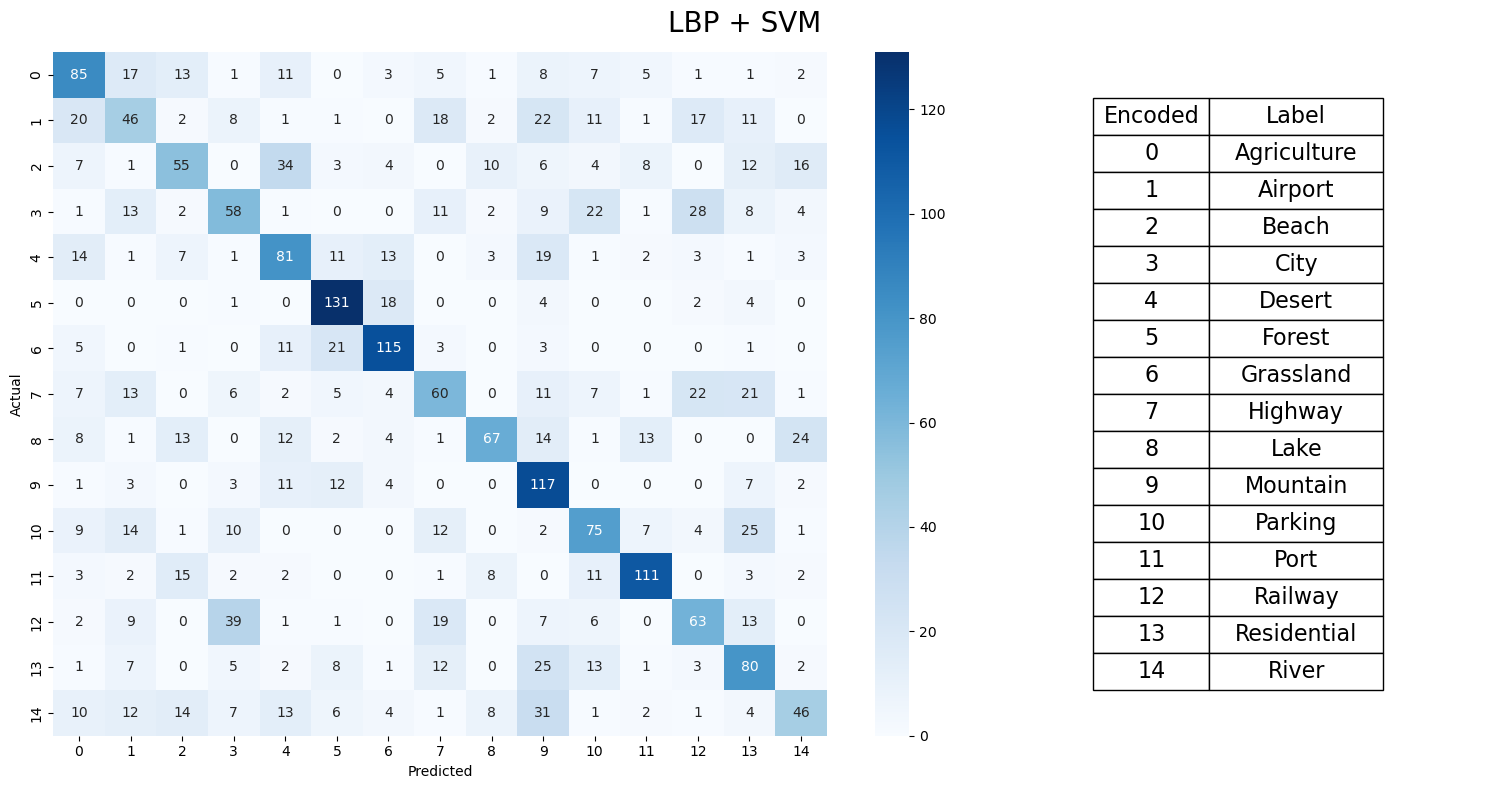

Accuracy: 0.4958
Precision: 0.4975
Recall: 0.4958
F1 Score: 0.4890


In [109]:
X_train_lbp = extract_lbp_features(train_images)
X_test_lbp = extract_lbp_features(test_images)

train_and_evaluate(X_train_lbp, train_labels, X_test_lbp, test_labels, class_names, method_name="LBP + SVM")



=== SIFT + LBP + SVM  ===
Accuracy:  0.7167
Precision: 0.7178
Recall:    0.7167
F1-score:  0.7157
              precision    recall  f1-score   support

 Agriculture       0.62      0.74      0.68       160
     Airport       0.54      0.54      0.54       160
       Beach       0.67      0.65      0.66       160
        City       0.68      0.79      0.73       160
      Desert       0.65      0.65      0.65       160
      Forest       0.82      0.91      0.86       160
   Grassland       0.74      0.68      0.71       160
     Highway       0.68      0.68      0.68       160
        Lake       0.66      0.53      0.59       160
    Mountain       0.80      0.82      0.81       160
     Parking       0.90      0.89      0.90       160
        Port       0.90      0.80      0.85       160
     Railway       0.71      0.71      0.71       160
 Residential       0.87      0.84      0.86       160
       River       0.53      0.52      0.53       160

    accuracy                       

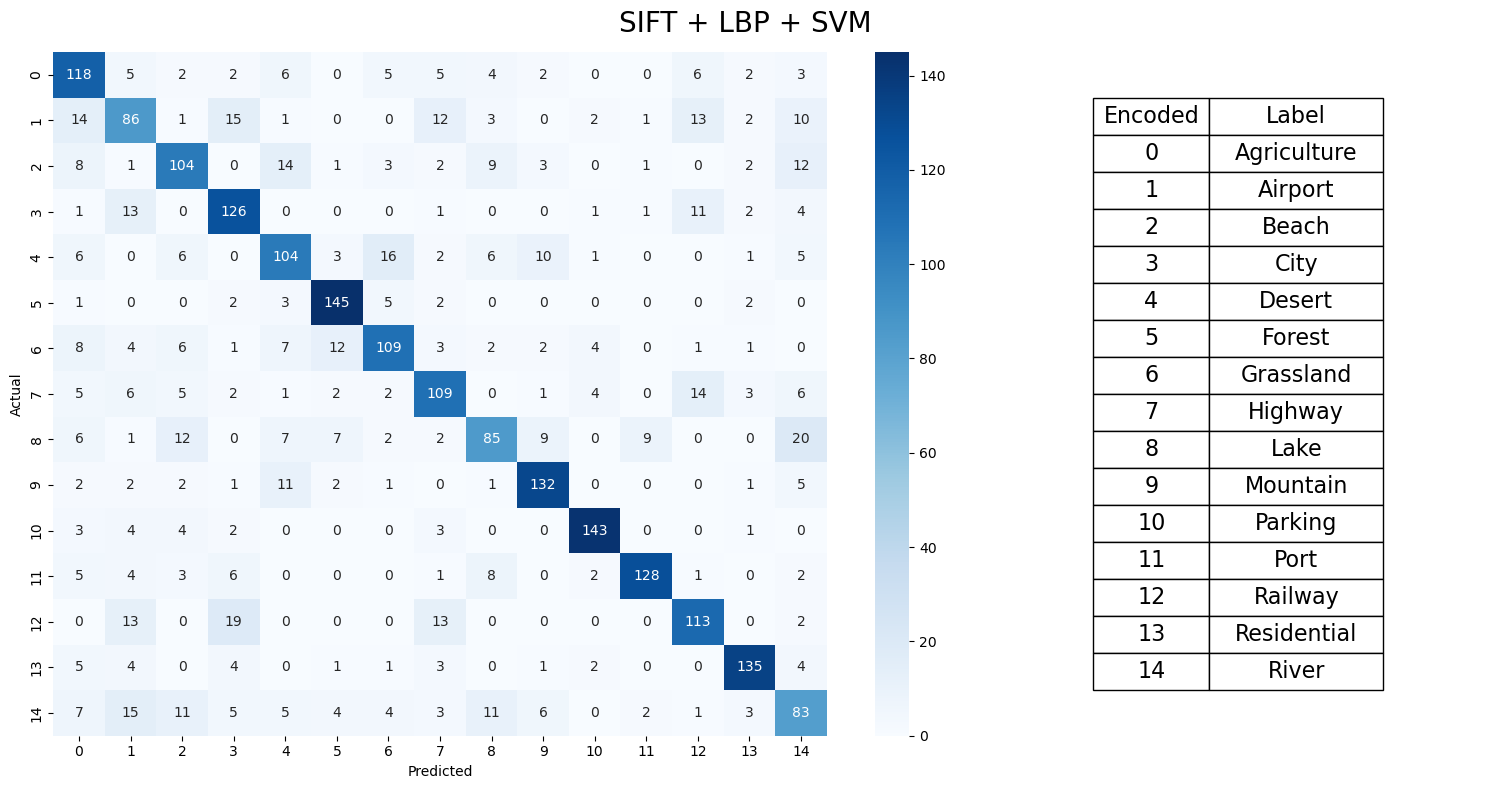

Accuracy: 0.7167
Precision: 0.7178
Recall: 0.7167
F1 Score: 0.7157


In [111]:
X_train_fused = np.hstack((X_train_sift, X_train_lbp))
X_test_fused = np.hstack((X_test_sift, X_test_lbp))

train_and_evaluate(X_train_fused, train_labels, X_test_fused, test_labels, class_names, method_name="SIFT + LBP + SVM")


In [113]:
from sklearn.neighbors import KNeighborsClassifier

def train_and_evaluate_knn(X_train, y_train, X_test, y_test, class_names, method_name="", k=3):
    # Standardize features using mean and variance
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize k-Nearest Neighbors classifier with k neighbors
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n=== {method_name}  ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred, average='macro'):.4f}")

    print("\n")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(confusion_matrix(y_test, y_pred))

    eval(y_pred, y_test, method_name, le)


Extracting SIFT descriptors...
Extracting SIFT descriptors...
Building visual vocabulary with 100 clusters...


E:\software\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Extracting Bag-of-Words features...
Extracting Bag-of-Words features...

=== SIFT + BoW + kNN  ===
Accuracy: 0.4967
Precision: 0.5403
Recall: 0.4967
F1-score: 0.4871


              precision    recall  f1-score   support

 Agriculture       0.51      0.51      0.51       160
     Airport       0.26      0.47      0.33       160
       Beach       0.66      0.31      0.42       160
        City       0.34      0.79      0.47       160
      Desert       0.49      0.34      0.40       160
      Forest       0.65      0.89      0.75       160
   Grassland       0.75      0.37      0.49       160
     Highway       0.40      0.44      0.42       160
        Lake       0.35      0.21      0.26       160
    Mountain       0.59      0.59      0.59       160
     Parking       0.85      0.71      0.78       160
        Port       0.73      0.34      0.46       160
     Railway       0.47      0.64      0.54       160
 Residential       0.64      0.70      0.67       160
       River       0.

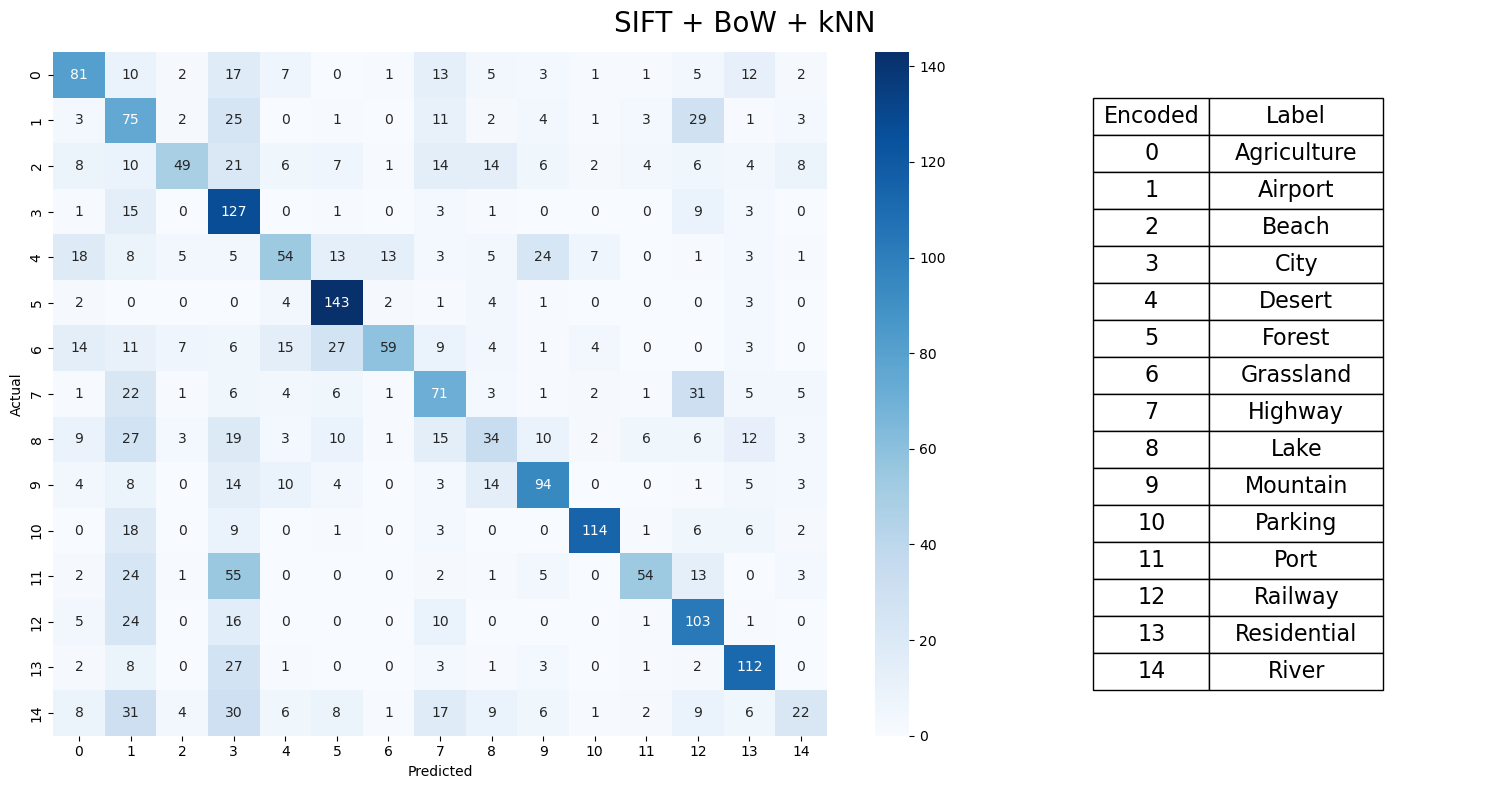

Accuracy: 0.4967
Precision: 0.5403
Recall: 0.4967
F1 Score: 0.4871


In [115]:
# Extract SIFT descriptors for training and test sets
train_desc = extract_sift_descriptors(train_images)
test_desc = extract_sift_descriptors(test_images)

# Build the visual vocabulary using k-means clustering
kmeans = build_visual_vocabulary(train_desc)

# Convert descriptors to Bag-of-Words histograms
X_train_sift = extract_bow_features(train_desc, kmeans)
X_test_sift = extract_bow_features(test_desc, kmeans)

# Train and evaluate kNN classifier using BoVW features
train_and_evaluate_knn(X_train_sift, train_labels, X_test_sift, test_labels, class_names, method_name="SIFT + BoW + kNN", k=3)


Extracting LBP features...
Extracting LBP features...

=== LBP + kNN  ===
Accuracy: 0.4900
Precision: 0.5109
Recall: 0.4900
F1-score: 0.4899


              precision    recall  f1-score   support

 Agriculture       0.38      0.64      0.48       160
     Airport       0.24      0.38      0.29       160
       Beach       0.42      0.46      0.44       160
        City       0.40      0.54      0.46       160
      Desert       0.47      0.48      0.48       160
      Forest       0.72      0.84      0.78       160
   Grassland       0.72      0.68      0.69       160
     Highway       0.41      0.31      0.35       160
        Lake       0.58      0.44      0.50       160
    Mountain       0.51      0.50      0.50       160
     Parking       0.57      0.32      0.41       160
        Port       0.70      0.61      0.65       160
     Railway       0.53      0.38      0.44       160
 Residential       0.54      0.49      0.52       160
       River       0.48      0.30      0.37   

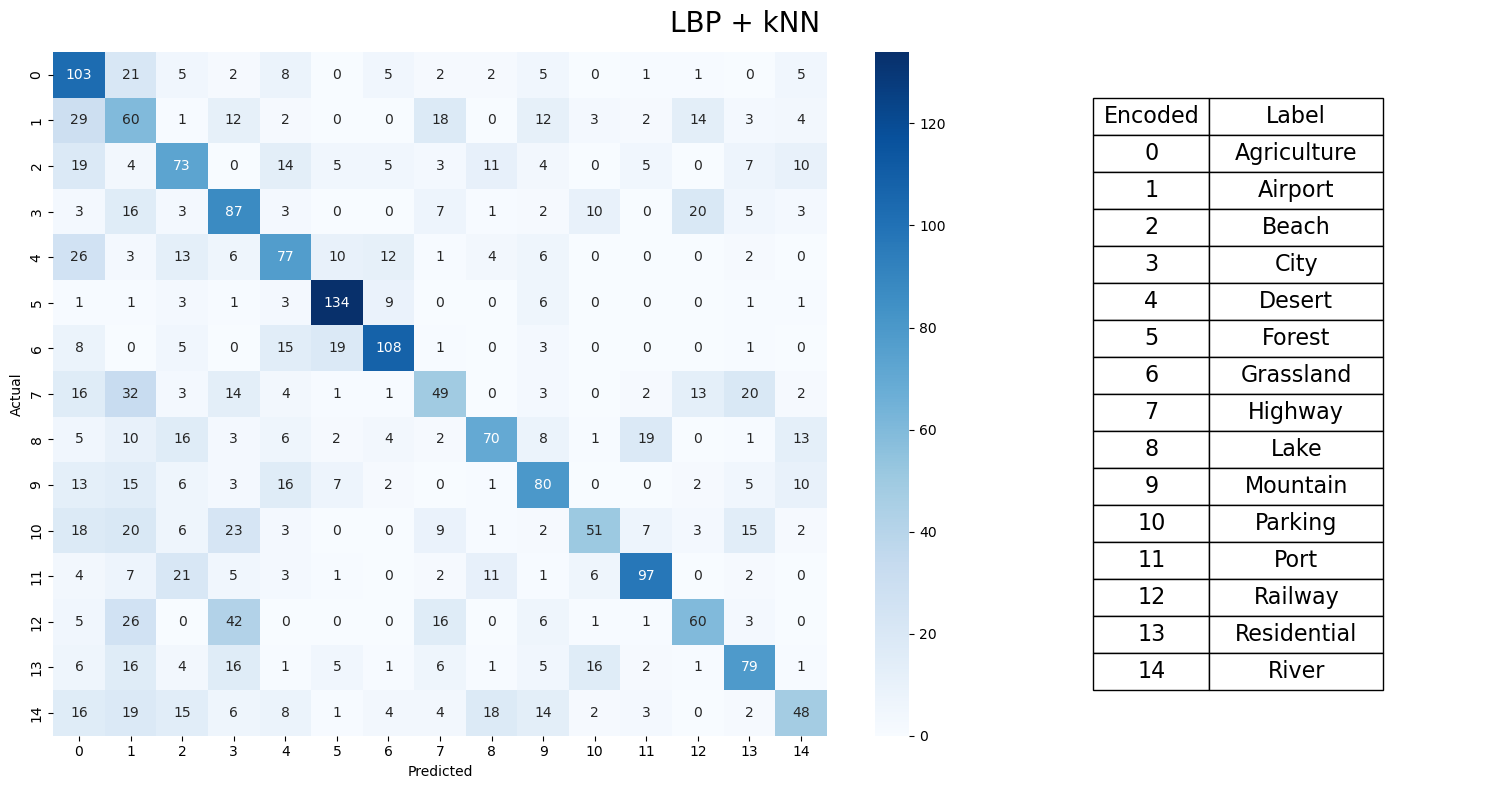

Accuracy: 0.4900
Precision: 0.5109
Recall: 0.4900
F1 Score: 0.4899


In [117]:
X_train_lbp = extract_lbp_features(train_images)
X_test_lbp = extract_lbp_features(test_images)

train_and_evaluate_knn(X_train_lbp, train_labels, X_test_lbp, test_labels, class_names, method_name="LBP + kNN", k=3)



=== SIFT + LBP + kNN  ===
Accuracy: 0.5863
Precision: 0.6105
Recall: 0.5863
F1-score: 0.5817


              precision    recall  f1-score   support

 Agriculture       0.57      0.56      0.56       160
     Airport       0.33      0.52      0.40       160
       Beach       0.65      0.40      0.49       160
        City       0.48      0.89      0.62       160
      Desert       0.62      0.49      0.55       160
      Forest       0.73      0.89      0.80       160
   Grassland       0.75      0.39      0.52       160
     Highway       0.46      0.47      0.47       160
        Lake       0.49      0.42      0.45       160
    Mountain       0.64      0.68      0.66       160
     Parking       0.94      0.74      0.83       160
        Port       0.86      0.72      0.79       160
     Railway       0.51      0.64      0.57       160
 Residential       0.69      0.75      0.72       160
       River       0.44      0.23      0.30       160

    accuracy                          

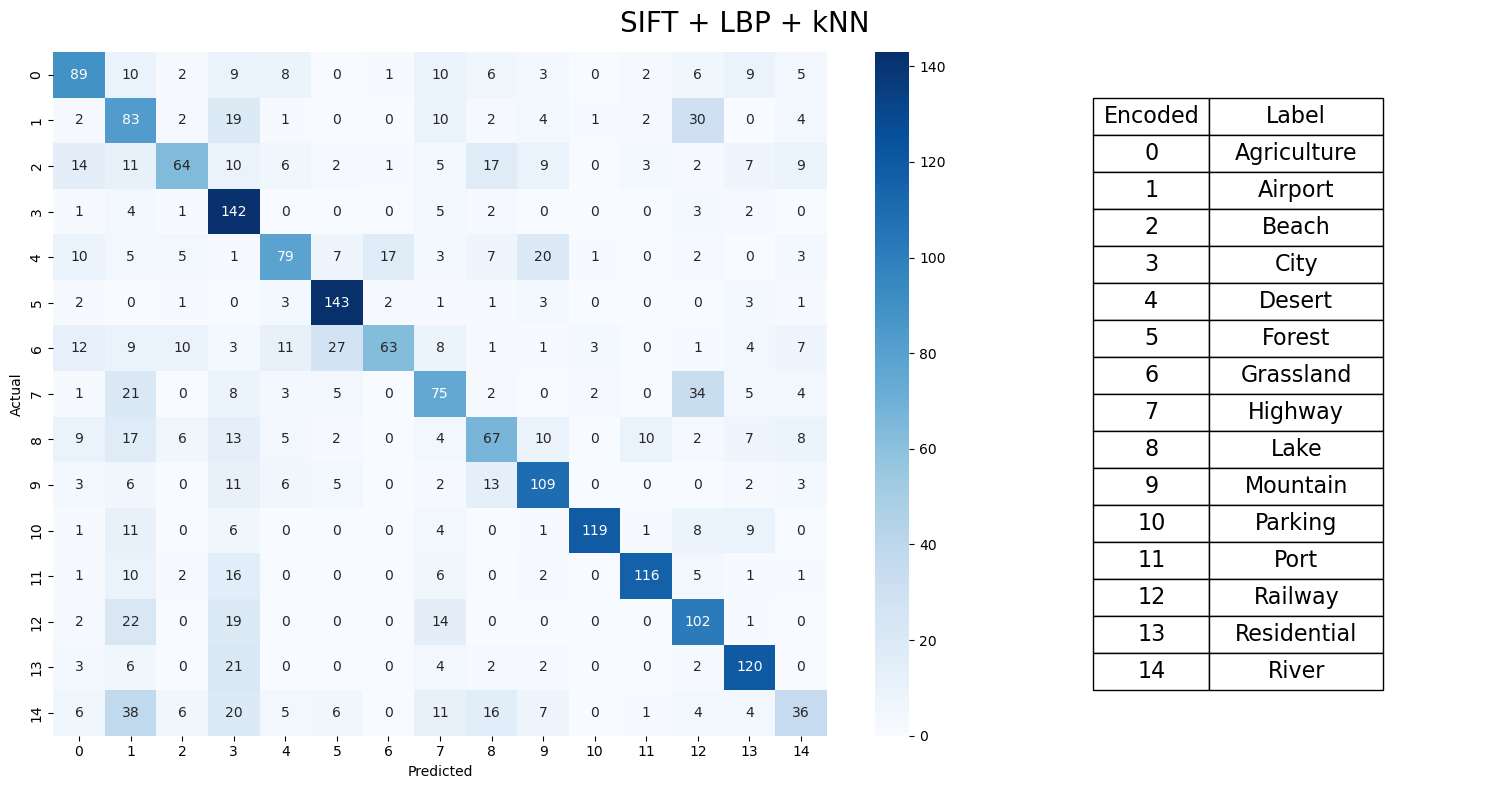

Accuracy: 0.5863
Precision: 0.6105
Recall: 0.5863
F1 Score: 0.5817


In [118]:
X_train_fused = np.hstack((X_train_sift, X_train_lbp))
X_test_fused = np.hstack((X_test_sift, X_test_lbp))

train_and_evaluate_knn(X_train_fused, train_labels, X_test_fused, test_labels, class_names, method_name="SIFT + LBP + kNN", k=3)
